In [24]:
import re
import unicodedata
import pandas as pd
import nltk
from wordcloud import WordCloud

from env import user, password, host, get_db_url

import acquire
import prepare

import warnings
warnings.filterwarnings('ignore')

In [2]:
url = get_db_url('spam_db', user, host, password)

In [3]:
sql = '''SELECT * FROM spam'''

## 1. Spam Data

### a. Load the spam data set.

In [4]:
df = pd.read_sql(sql,url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [5]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [6]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [7]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [8]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [9]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
2       173
u       155
txt     150
dtype: int64

In [10]:
ham_freq.head()

u       1027
im       449
get      314
2        305
ltgt     276
dtype: int64

In [11]:
all_freq.head()

u       1182
call     600
2        478
im       462
get      397
dtype: int64

In [12]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [14]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,ham,spam
u,1182,1027,155
call,600,241,359
2,478,305,173
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5


In [15]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(10),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(10)])

,all,ham,spam
amp,82,82,0
said,86,86,0
ask,88,88,0
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
ltgt,276,276,0


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# prep
ham_words = prepare.basic_clean(' '.join(df[df.label == 'ham'].text))
ham_words = prepare.tokenize(ham_words)
ham_words = prepare.remove_stopwords(ham_words)
ham_words = prepare.lemmatize(ham_words)

spam_words = prepare.basic_clean(' '.join(df[df.label == 'spam'].text))
spam_words = prepare.tokenize(spam_words)
ham_words = prepare.remove_stopwords(ham_words)
spam_words = prepare.lemmatize(spam_words)

all_words = ham_words + spam_words

In [20]:
# split
ham_bis = list(nltk.ngrams(ham_words.split(), 2))
spam_bis = list(nltk.ngrams(spam_words.split(), 2))
all_bis = list(nltk.ngrams(all_words.split(), 2))

In [21]:
ham_bi_counts = pd.concat([pd.Series(ham_bis).value_counts()])
spam_bi_counts = pd.concat([pd.Series(spam_bis).value_counts()])
all_bi_counts = pd.concat([pd.Series(all_bis).value_counts()])

bi_counts = (pd.concat([ham_bi_counts, spam_bi_counts, all_bi_counts], axis=1)
               .set_axis(['ham', 'spam', 'all'], axis=1, inplace=False) 
             .fillna(0).apply(lambda s: s.astype(int)).sort_values(by='all', ascending=False))
bi_counts

,,ham,spam,all
you,have,0,73,73
have,won,0,54,54
please,call,9,44,53
call,later,52,0,52
your,mobile,0,49,49
...,...,...,...,...
say,everything,1,0,1
gave,pain,1,0,1
doc,gave,1,0,1
true,namefree,0,0,1


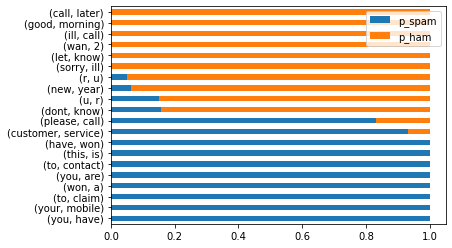

In [22]:
(bi_counts
 .assign(p_spam=bi_counts.spam / bi_counts['all'],
         p_ham=bi_counts.ham / bi_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))
plt.show()

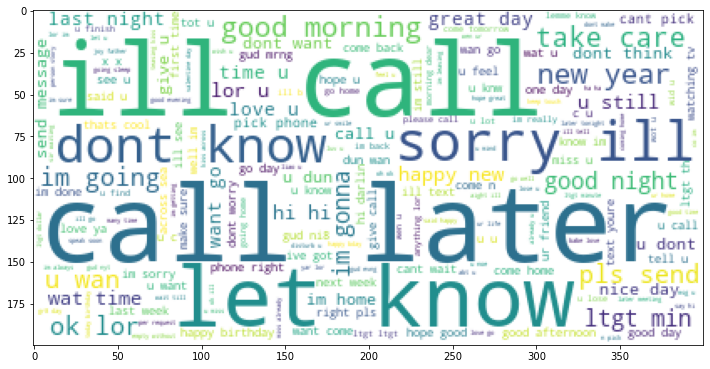

In [28]:
# ham bigrams
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white',
                collocation_threshold = 3).generate(ham_words)
plt.imshow(img)
plt.show()

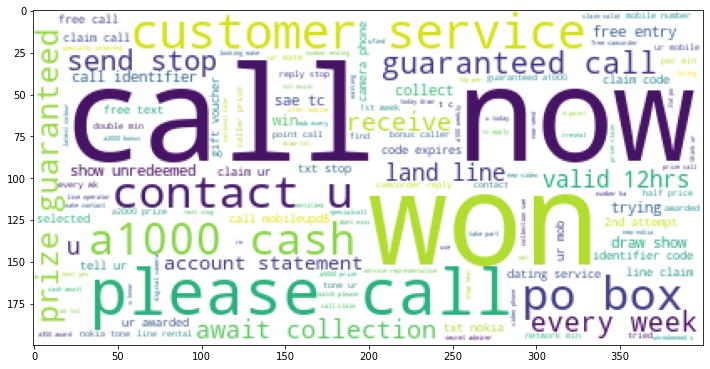

In [29]:
# ham bigrams
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white',
                collocation_threshold = 3).generate(spam_words)
plt.imshow(img)
plt.show()

### c. Is there any overlap in the bigrams for the spam data and the ham data?

In [30]:
intersection = set(ham_bis).intersection(set(spam_bis))

In [31]:
intersection_counts = bi_counts[bi_counts.index.isin(intersection)]

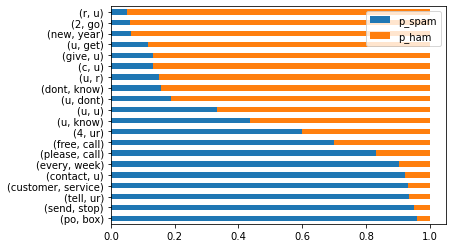

In [33]:
(intersection_counts
 .assign(p_spam=bi_counts.spam / intersection_counts['all'],
         p_ham=bi_counts.ham / intersection_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))
plt.show()

### d. Create and explore trigrams for both the spam and ham data.

In [34]:
ham_tris = list(nltk.ngrams(ham_words.split(), 3))
spam_tris = list(nltk.ngrams(spam_words.split(), 3))
all_tris = list(nltk.ngrams(all_words.split(), 3))

ham_tris = ['_'.join(tri) for tri in ham_tris]
spam_tris = ['_'.join(tri) for tri in spam_tris]
all_tris = ['_'.join(tri) for tri in all_tris]

In [35]:
ham_tri_counts = pd.concat([pd.Series(ham_tris).value_counts()])
spam_tri_counts = pd.concat([pd.Series(spam_tris).value_counts()])
all_tri_counts = pd.concat([pd.Series(all_tris).value_counts()])

tri_counts = (pd.concat([ham_tri_counts, spam_tri_counts, all_tri_counts], axis=1)
               .set_axis(['ham', 'spam', 'all'], axis=1, inplace=False) 
             .fillna(0).apply(lambda s: s.astype(int)).sort_values(by='all', ascending=False))
tri_counts

,ham,spam,all
ill_call_later,42,0,42
sorry_ill_call,38,0,38
you_have_won,0,37,37
have_won_a,0,35,35
u_wan_2,21,0,21
...,...,...,...
u_get_paid,1,0,1
shopping_u_get,1,0,1
take_shopping_u,1,0,1
namefree_entry_in,0,0,1


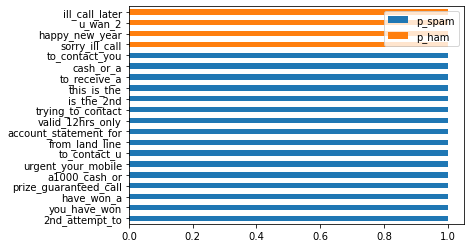

In [36]:
(tri_counts
 .assign(p_spam=tri_counts.spam / tri_counts['all'],
         p_ham=tri_counts.ham / tri_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))
plt.show()

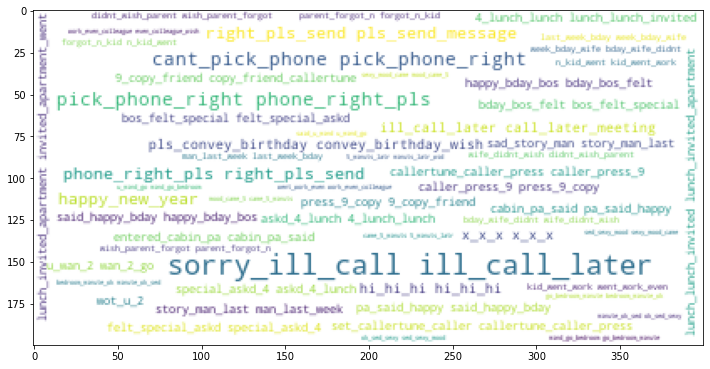

In [37]:
# ham_tris
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white').generate(' '.join(ham_tris))
plt.imshow(img)
plt.show()

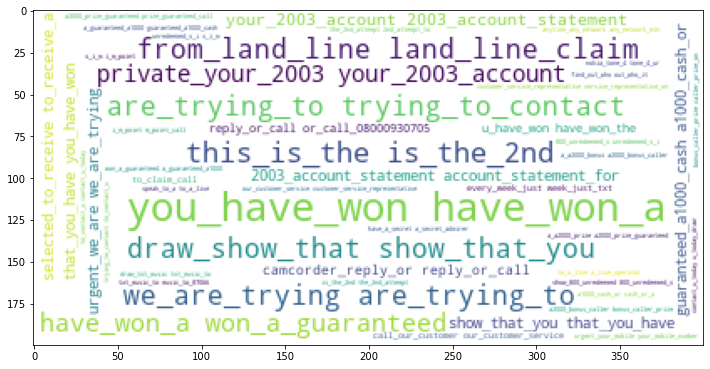

In [38]:
# spam_tris
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white').generate(' '.join(spam_tris))
plt.imshow(img)
plt.show()

## 2. Blog Articles

In [39]:
df = acquire.get_blog_articles()
df = prepare.nlp_prep(df)
blog_words = ' '.join(df.clean)

Reading from local CSV...


In [40]:
blog_freq = pd.Series([word for word in blog_words.split()]).value_counts()
blog_freq.head(10)

codeup      733
data        654
career      352
science     311
like        296
job         294
get         275
learn       260
program     256
students    244
dtype: int64

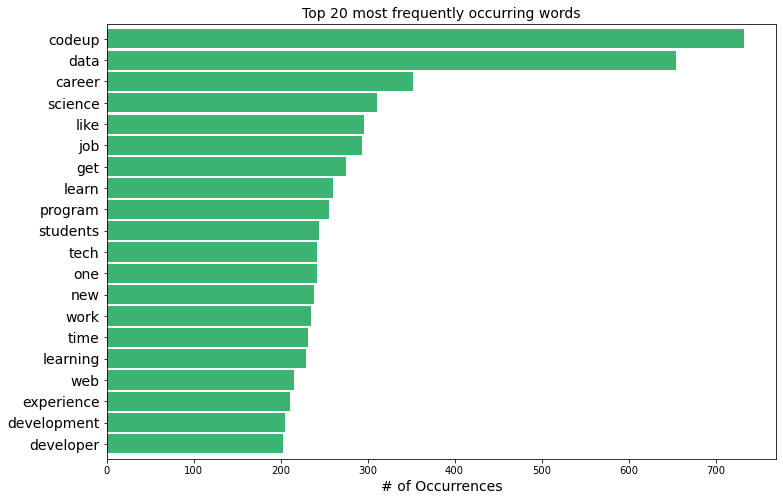

In [41]:
top_20_words = blog_freq.head(20)
top_20_words.sort_values().plot.barh(color='mediumseagreen', 
                                     width=.9, 
                                     figsize=(12,8))
plt.title('Top 20 most frequently occurring words', fontsize=14)
plt.xlabel('# of Occurrences', fontsize=14)
plt.yticks(fontsize=14)
plt.show()


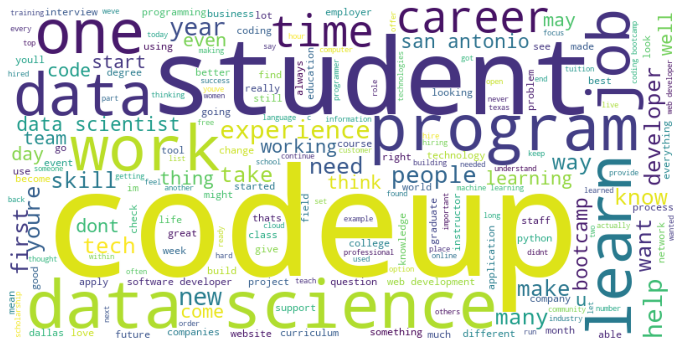

In [42]:
img = WordCloud(background_color='white', width=800, height=400).generate(blog_words)
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [43]:
bigrams = list(nltk.ngrams(blog_words.split(), 2))
bigrams = ['_'.join(bi) for bi in bigrams]
bigram_freq = pd.Series(bigrams).value_counts()

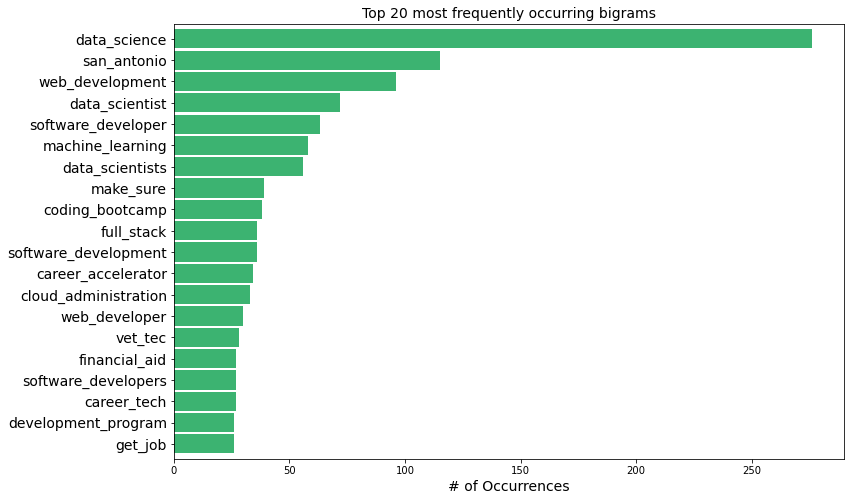

In [44]:
top_20_bis = bigram_freq.head(20)
top_20_bis.sort_values().plot.barh(color='mediumseagreen', 
                                     width=.9, 
                                     figsize=(12,8))
plt.title('Top 20 most frequently occurring bigrams', fontsize=14)
plt.xlabel('# of Occurrences', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

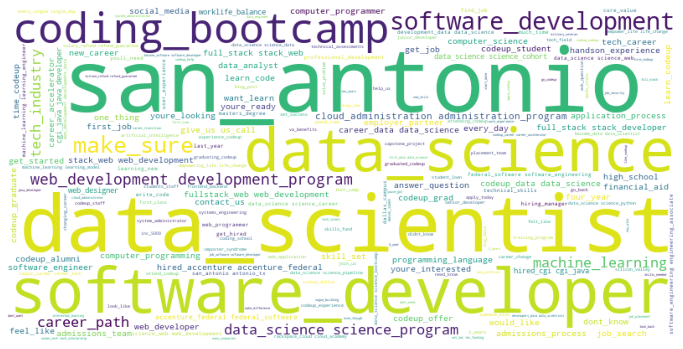

In [45]:
img = WordCloud(background_color='white', width=800, height=400).generate(' '.join(bigrams))
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

## 3. News Articles

In [46]:
df = acquire.get_news_articles()
df = prepare.nlp_prep(df)
df.head(3)

Reading from local CSV...


,title,author,original,category,clean,stemmed,lemmatized
0,India's GDP grows at 13.5% in first quarter of...,Anmol Sharma,India's GDP grew at 13.5% in the first quarter...,business,indias gdp grew 135 first quarter fy23 achievi...,india gdp grew 135 first quarter fy23 achiev f...,india gdp grew 135 first quarter fy23 achievin...
1,"Snap to lay off 20% of staff, cancel several p...",Ananya Goyal,Snap said on Wednesday it will lay off 20% of ...,business,snap said wednesday lay 20 staff shut original...,snap said wednesday lay 20 staff shut origin s...,snap said wednesday lay 20 staff shut original...
2,2 top executives at Snap quit hours after repo...,Ridham Gambhir,Two senior advertising executives at Snap quit...,business,two senior advertising executives snap quit ho...,two senior advertis execut snap quit hour repo...,two senior advertising executive snap quit hou...


In [47]:
words = ' '.join(df.clean)
word_freq = pd.Series(words.split()).value_counts()

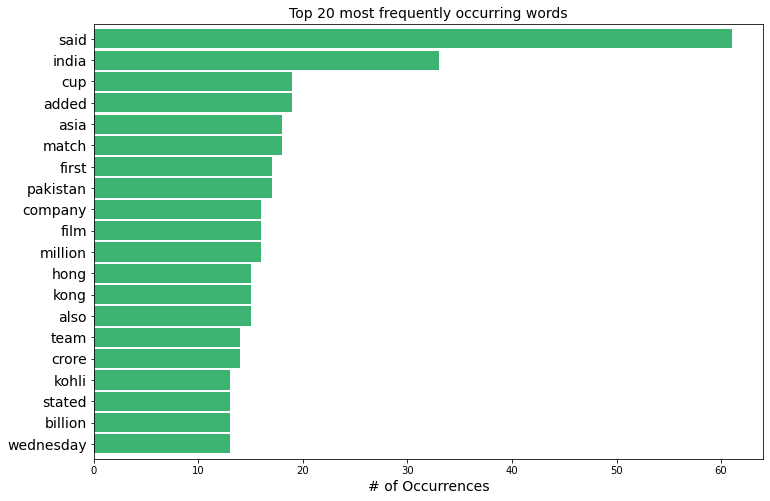

In [48]:
top_20 = word_freq.head(20)
top_20.sort_values().plot.barh(color='mediumseagreen', 
                                     width=.9, 
                                     figsize=(12,8))
plt.title('Top 20 most frequently occurring words', fontsize=14)
plt.xlabel('# of Occurrences', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [49]:
business_words = ' '.join(df[df.category == 'business'].clean)
sports_words = ' '.join(df[df.category == 'sports'].clean)
tech_words = ' '.join(df[df.category == 'technology'].clean)
entertainment_words = ' '.join(df[df.category == 'entertainment'].clean)
all_words = ' '.join(df.clean)

In [50]:
business_freq = pd.Series(business_words.split()).value_counts()
sports_freq = pd.Series(sports_words.split()).value_counts()
tech_freq = pd.Series(tech_words.split()).value_counts()
entertainment_freq = pd.Series(entertainment_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()


In [51]:
word_counts = (pd.concat([all_freq, 
                          business_freq, 
                          sports_freq, 
                          tech_freq,
                          entertainment_freq], axis=1, sort=True)
                .set_axis(['all', 'business', 'sports', 'tech', 'entertainment'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [52]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,business,sports,tech,entertainment
said,61,8,16,16,21
india,33,5,21,4,3
added,19,0,10,2,7
cup,19,0,19,0,0
match,18,0,18,0,0
asia,18,0,18,0,0
pakistan,17,2,15,0,0
first,17,8,3,1,5
million,16,7,0,9,0
company,16,8,0,8,0


In [53]:
# words that uniquely identify a particular category
categories = ['business', 'sports', 'tech', 'entertainment']

unique_words = pd.DataFrame()
for category in categories:
    pd.concat([unique_words, word_counts[word_counts.all == word_counts[category]]])
    
unique_words.shape
# there are no words that uniquely identify one category

(0, 0)

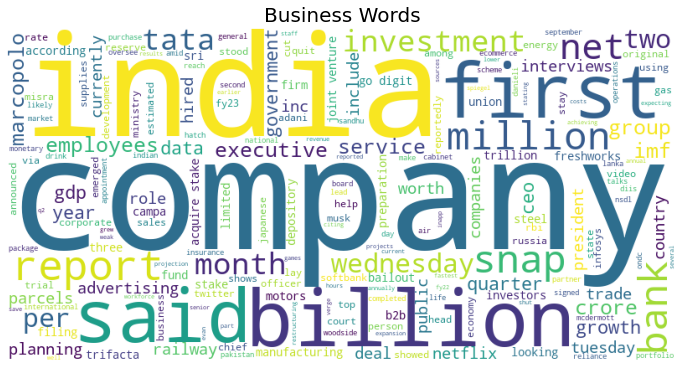

In [54]:
# business words
img = WordCloud(background_color='white', width=800, height=400).generate(business_words)
plt.figure(figsize=(12,8))
plt.title('Business Words', fontsize=20)
plt.imshow(img)
plt.axis('off')
plt.show()


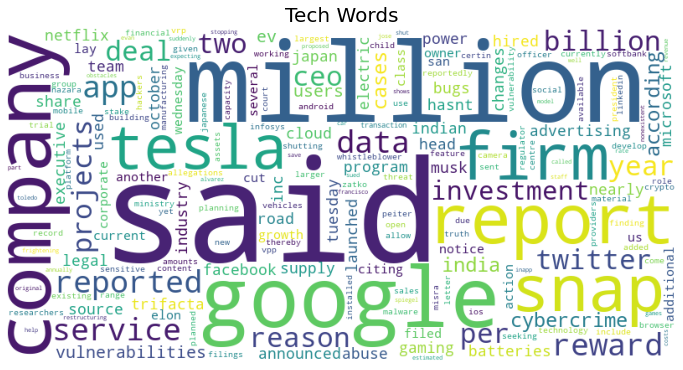

In [55]:
# tech words
img = WordCloud(background_color='white', width=800, height=400).generate(tech_words)
plt.figure(figsize=(12,8))
plt.title('Tech Words', fontsize=20)
plt.imshow(img)
plt.axis('off')
plt.show()

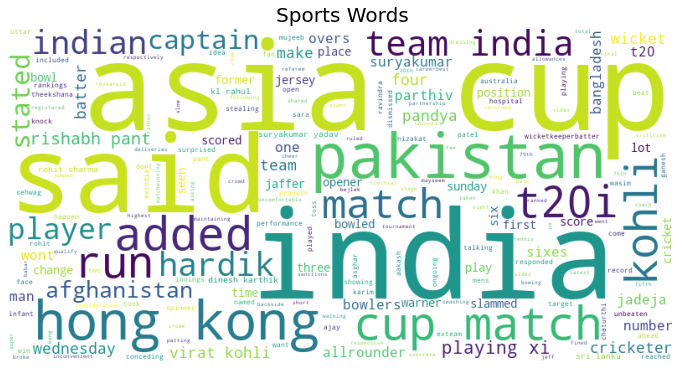

In [56]:
# sports words
img = WordCloud(background_color='white', width=800, height=400).generate(sports_words)
plt.figure(figsize=(12,8))
plt.title('Sports Words', fontsize=20)
plt.imshow(img)
plt.axis('off')
plt.show()

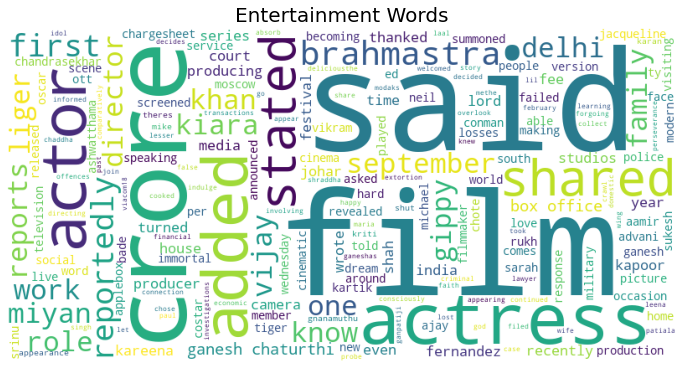

In [57]:
# entertainment words
img = WordCloud(background_color='white', 
                width=800, 
                height=400).generate(entertainment_words)
plt.figure(figsize=(12,8))
plt.title('Entertainment Words', fontsize=20)
plt.imshow(img)
plt.axis('off')
plt.show()

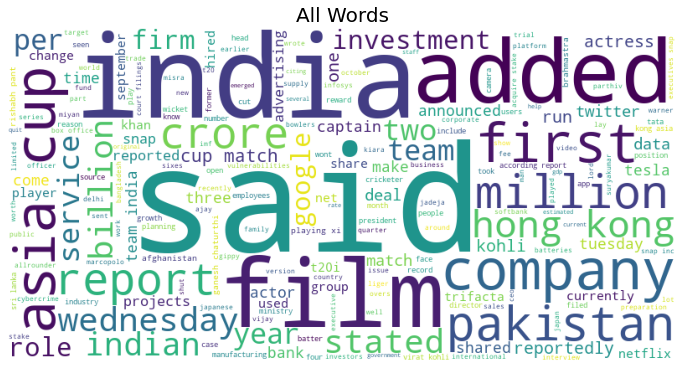

In [58]:
# all words
img = WordCloud(background_color='white', 
                width=800, 
                height=400).generate(all_words)
plt.figure(figsize=(12,8))
plt.title('All Words', fontsize=20)
plt.imshow(img)
plt.axis('off')
plt.show()
